In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import sys
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
sys.path.append('../src/')

# custom scripts
from visualization import plot_batch
from helpers import get_fourier_transform
from spiraltrajectory import spiral_samples_trajectory, kspace_measurements_spiral, minimum_energy_reconstruction
from mri_cs import lpminimization, hermitian

from nfft import nfft, ndft
from matplotlib.colors import LogNorm
from numpy.fft import fft2, fftshift
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
IMG_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.img'
HEADER_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.hdr'

imgs = nib.load(IMG_PATH)
data = imgs.get_data()
img = data.T[0]

<ipython-input-2-43f7d2574cad>:5: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



## Plot transposed image

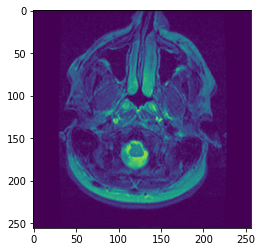

In [3]:
_ = plt.imshow(img)

## 2d Fourier Transform

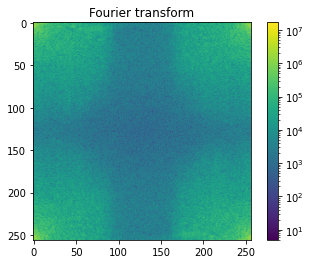

In [4]:
def plot_spectrum(im_fft):
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

im_fft = get_fourier_transform(img, fshift=False, use_absolute=False)
plot_spectrum(im_fft)
_ = plt.title('Fourier transform')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe0425f3640>,
 <matplotlib.image.AxesImage at 0x7fe04254a670>)

(Text(0.5, 1.0, 'Input Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fe04254aa90>,
 <matplotlib.image.AxesImage at 0x7fe0424ecf10>)

(Text(0.5, 1.0, 'Magnitude Spectrum'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

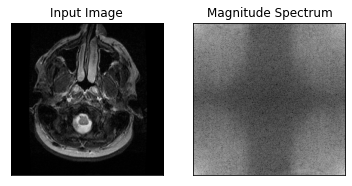

In [5]:
transformed_imgs = [get_fourier_transform(img, use_absolute=True) for img in data.T]

plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(transformed_imgs[0], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

## K-space Spiral Trajectory

<Figure size 576x576 with 0 Axes>

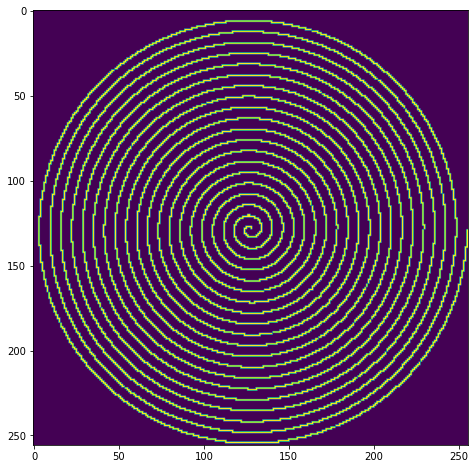

In [6]:
img_size = 256
samples_rows, i, j, I =  spiral_samples_trajectory(width=img_size, height=img_size, n_turns=20)

plt.figure(figsize=(8,8))
_ = plt.imshow(np.fft.fftshift(I))

# Get K Space measurements

In [7]:
measurements = kspace_measurements_spiral(img, samples_rows)
measurements.size

10173

# Reconstruct image with minimum energy algorithm

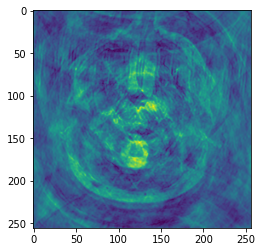

In [8]:
reconstructed_img = minimum_energy_reconstruction(measurements, 256, 256, samples_rows)
_ = plt.imshow(np.abs(reconstructed_img))

In [10]:
N = 1024
eta = int(0.1 * N)

def generate_X(N, eta):
    if isinstance(N, int):
        T = np.random.randn(N, N)
    else:
        T = N
        N = T.shape[0]
    
    X_hat = np.zeros((N, 1))
    
    non_zero_indices = np.random.permutation(N)[:eta]
    rand_elements = np.reshape(np.random.randn(eta), [eta, 1])
    print(rand_elements.shape)
    print(X_hat.shape)
    print(T.shape)
    
    X_hat[non_zero_indices] = rand_elements
    
    # T^-1 * X_hat
    X = np.linalg.solve(T, X_hat)

    return X, X_hat, non_zero_indices, T

X, X_hat, non_zero_indices, T = generate_X(N, eta)
# medidas colhidas para reconstrucao
ell = 6 * eta
M = np.random.randn(ell, N)
b = np.dot(M, X)
# reconstrucao do sinal a partir das medidas
A = np.dot(M, np.linalg.inv(T))
Ah = hermitian(A)
A_ = lambda x: np.dot(A, x)
Ah_ = lambda x: np.dot(Ah, x)

X_hat_r = lpminimization(A_, Ah=Ah_, b=b, p=1, N=N)
# DEBUG metodo direto
# N = A.shape[1]
# X_hat_r = lpminimization(A, b=b, p=1)

(102, 1)
(1024, 1)
(1024, 1024)
Starting stage 1
    Iteration 1
Starting stage 2
    Iteration 1
    Iteration 2
    Iteration 3
Starting stage 3
    Iteration 1
    Iteration 2
    Iteration 3
    Iteration 4
    Iteration 5
    Iteration 6
Starting stage 4
    Iteration 1
    Iteration 2
    Iteration 3
    Iteration 4
    Iteration 5
    Iteration 6
    Iteration 7
Starting stage 5
    Iteration 1
    Iteration 2
    Iteration 3
    Iteration 4
    Iteration 5
    Iteration 6
Starting stage 6
    Iteration 1
    Iteration 2
    Iteration 3
    Iteration 4
    Iteration 5
Starting stage 7
    Iteration 1
    Iteration 2
    Iteration 3
Starting stage 8
    Iteration 1
    Iteration 2
    Iteration 3
Starting stage 9
    Iteration 1
    Iteration 2
Starting stage 10
    Iteration 1
    Iteration 2


<Figure size 1008x720 with 0 Axes>

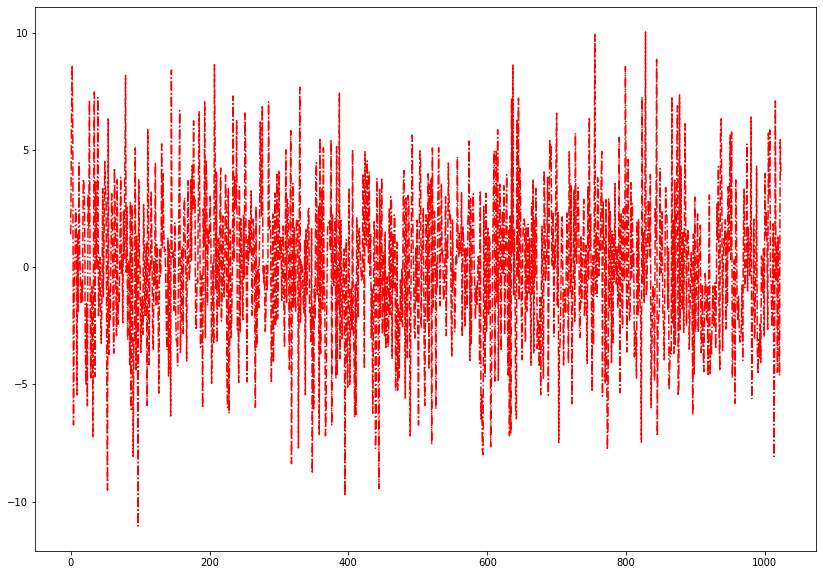

In [11]:
# X_hat_r
Xr = np.linalg.solve(T, X_hat_r)
X = np.reshape(X, [X.shape[0],])

plt.figure(figsize=(14, 10))
plt.plot(Xr, color="red", linestyle="-.")
plt.show()
# plt.plot(X)

<Figure size 1008x720 with 0 Axes>

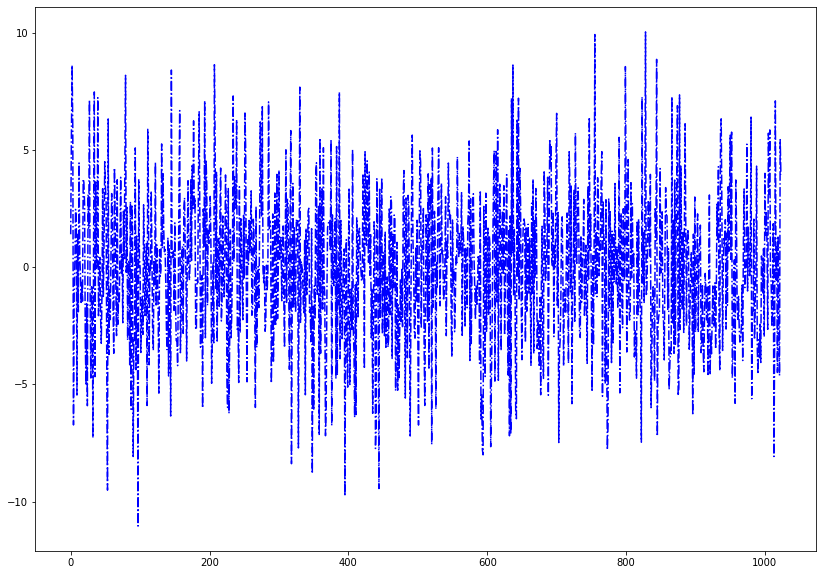

In [12]:
plt.figure(figsize=(14, 10))
plt.plot(X, color="blue", linestyle="-.")

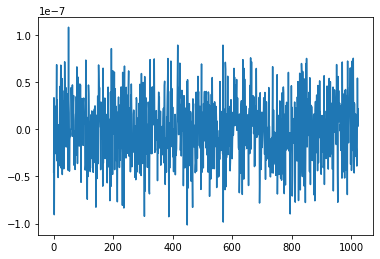

In [13]:
err = Xr - X
plt.plot(err)

In [14]:
# Fazer Grafico comparando ser_db com numero de medidas 
# direto vs indireto
# norma L2
# relacao = norma(sinal) / norma(ruido)
# relacao sinal x erro: um numero q reflete quao proximos estao. Quanto mais proximos, maior a relacao
# qualidade da reconstrucao
X.shape

signal_energy = np.sum(X**2)
error_energy = np.sum(err**2)
signal_energy
error_energy

# signal / error ratio
ser = signal_energy / error_energy
ser_db = 10 * np.log10(ser)
ser
ser_db

(1024,)

11428.69293618382

1.1820678825768587e-12

9668389696258176.0

159.8535414685805